This notebook is mainly for figuring out how to manipulate the mock catalogues in the ways we want, with the goal of transitioning to scripts / package functions later on

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import pandas as pd
from mpl_toolkits.basemap import Basemap
# plt.style.use('dark_background')
from astropy import units as u
from astropy.coordinates import SkyCoord
import glob 

In [2]:
from mock_utils.load_supermock import *
from mock_utils.sample_analysis_utils import *

In [3]:
# load in catalog files
test_data, test_items = load_all_available_catalogs(dirIn = 'Downsampled_SuperMocks/') # Read all the available files

Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_0_every_1000.hdf5
Total number of original galaxies: 7169
Total number of cleaned galaxies: 4257
Total number of removed galaxies: 2912
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_1_every_1000.hdf5
Total number of original galaxies: 7062
Total number of cleaned galaxies: 3966
Total number of removed galaxies: 3096
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_2_every_1000.hdf5
Total number of original galaxies: 7005
Total number of cleaned galaxies: 3943
Total number of removed galaxies: 3062
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5
Total number of original galaxies: 7128
Total number of cleaned galaxies: 4253
Total number of removed galaxies: 2875
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_Sup

In [4]:
# extract the info we want and remove the rest
ra_full = np.array(test_data['ra_true'])
dec_full = np.array(test_data['dec_true'])
redshift = np.array(test_data['redshift_true'])

del test_data

In [9]:
ra_cut = ra_full[(redshift < 0.5)]
dec_cut = dec_full[(redshift < 0.5)]
redshift_cut = redshift[(redshift < 0.5)]

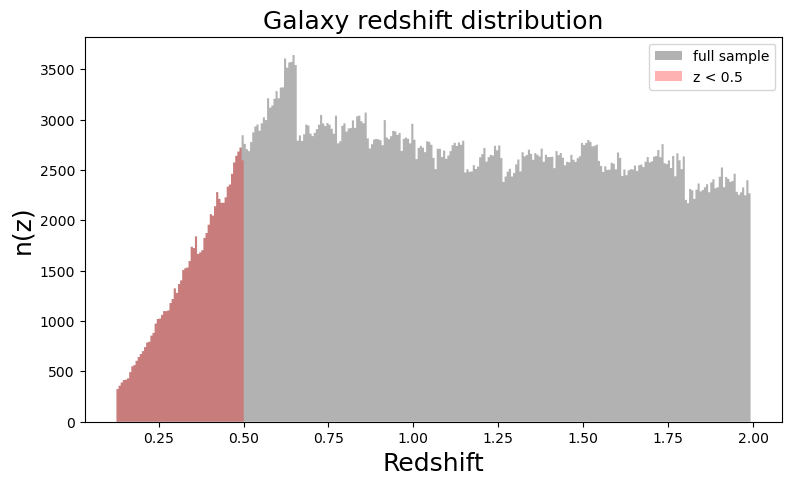

In [11]:
# plot the redshift distribution
plt.figure(figsize=(9, 5))
nbins = np.linspace(np.amin(redshift), np.amax(redshift), 300)
plt.hist( redshift, bins = nbins, label='full sample', alpha=0.3, color='k', histtype='stepfilled', lw=2);
plt.hist( redshift_cut, bins = nbins, label='z < 0.5', alpha=0.3, color='r', histtype='stepfilled', lw=2);

plt.title('Galaxy redshift distribution', fontsize=18)
plt.xlabel('Redshift', fontsize=18)
plt.ylabel('n(z)', fontsize=18)
# plt.xlim(0, 0.52)
plt.legend()

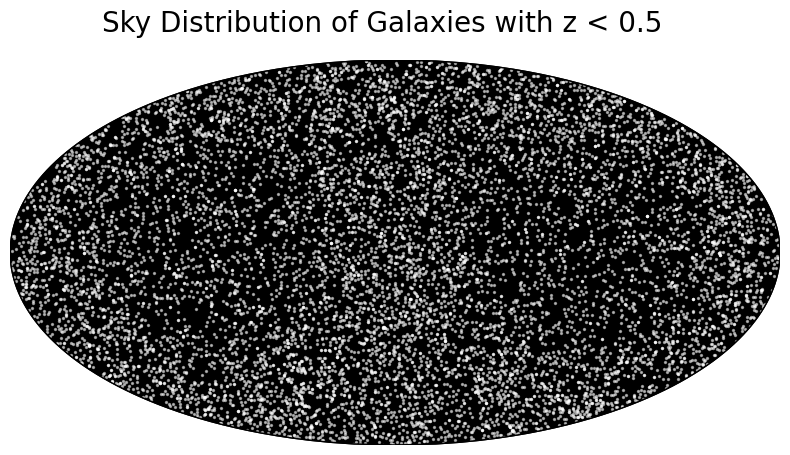

In [14]:
# visualize the cut sample's distribution on the full sky
fig = plt.figure(figsize=(10, 5))

##########################
ax = fig.add_subplot(111)

# Only plotting random 10,000 galaxies
n_gal = 10000
random_gal_indices = np.random.randint(low=0, high=ra_cut.shape[0], size=n_gal)

ra_octant = ra_cut[random_gal_indices]
dec_octant = dec_cut[random_gal_indices]

# Define the orthographic projection centered on the equator and prime meridian
m = Basemap(projection='moll', lat_0=-60, lon_0=90, resolution='c')
# Convert RA, Dec to x, y coordinates for plotting
x, y = m(ra_octant, dec_octant)

# Plot the sky distribution
m.scatter(x, y, s=2, c='white', alpha=0.5, edgecolors='w', linewidth=1)

# Draw parallels and meridians
# m.drawparallels(np.arange(-90.,90.,22.5), color='yellow', textcolor='yellow', linewidth=2)
# m.drawmeridians(np.arange(0.,360.,22.5), color='yellow', textcolor='yellow', linewidth=2)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color='black', linewidth=0.5)
 
plt.suptitle('Sky Distribution of Galaxies with z < 0.5', fontsize=20)
plt.show()